In [226]:
import os
import sys
import urllib, io
import pickle

import numpy as np
import scipy.stats as stats
import pandas as pd
from sklearn.metrics import euclidean_distances, jaccard_score, pairwise_distances

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 
from IPython.core.display import HTML 

from io import BytesIO
import base64
import requests

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

sys.path.append("../../stimuli/block_utils/")
import blockworld_utils as utils

In [227]:
experiment_name = 'build_recall'

## directory & file hierarchy
proj_dir = os.path.abspath('../..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir = os.path.abspath(os.path.join(os.getcwd(),'..'))
results_dir = os.path.join(proj_dir,'results')

# paths specific to this experiment
experiment_results_dir = os.path.join(results_dir, experiment_name)
plot_dir = os.path.join(experiment_results_dir,'plots')
csv_dir = os.path.join(experiment_results_dir,'csv')
json_dir = os.path.join(experiment_results_dir,'json')

png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))
jefan_dir = os.path.join(analysis_dir,'jefan')
will_dir = os.path.join(analysis_dir,'will')

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

In [228]:
# set vars 
auth = pd.read_csv(os.path.join(proj_dir, 'auth.txt'), header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'cogtoolslab.org' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['block_construction']
coll = db['build_components']

# which iteration name should we use?
# iteration_name = 'build_components_build_recall_prolific_pilot_12_towers'
# iteration_name = 'build_components_build_recall_prolific_pilot_6_towers_2_rep'
# iteration_name = 'build_components_build_recall_6_towers_3_rep_color_sona_pilot_0'
# iteration_name = 'build_components_build_recall_6_towers_3_rep_color_sona_pilot_1'
iteration_name = 'build_components_build_recall_6_towers_3_rep_color_sona_pilot_1_datatest'
iteration_names = [iteration_name]

In [229]:
! tunnel_cogtoolslab

zsh:1: command not found: tunnel_cogtoolslab


In [236]:
# all data
query = coll.find({"$and":[
                        {'iterationName': { '$in': iteration_names }},
                        ]})
df_all = pd.DataFrame(query)
print(len(df_all))

21422


In [237]:
df_all.columns

Index(['_id', 'rt', 'url', 'trial_type', 'trial_index', 'time_elapsed',
       'internal_node_id', 'experimentName', 'iterationName', 'workerID',
       'gameID', 'studyLocation', 'datatype', 'view_history',
       'trial_start_time', 'trial_finish_time', 'condition', 'stimulus',
       'response', 'trial_num', 'towerColor', 'block_str', 'tower_id',
       'tower_A_tall_id', 'tower_A_wide_id', 'tower_B_tall_id',
       'tower_B_wide_id', 'tower_id_tall', 'composite_id',
       'n_blocks_when_reset', 'absolute_time', 'relative_time', 'n_block',
       'n_resets', 'timeAbsolute', 'timeRelative', 'blocks', 'discreteWorld',
       'eventType', 'block', 'endReason', 'rep', 'assignmentID', 'trials',
       'composite_url_stem', 'numGames', 'games', 'response_key_list',
       'response_key_dict', 'response_key_invert', 'color', 'correct',
       'locations', 'target_present', 'set_size', 'success', 'timeout',
       'failed_images', 'failed_audio', 'failed_video', 'img_src',
       'img_posi

In [238]:
df_all.workerID.unique()

array([None, '37960', '50860', '45884', '45420', '50249', '45055',
       '45727', '49988', '45185', '46175', '48742', '45871', '42146',
       '50844', '42031', '45176', '44439', '45702', '37407', '49109',
       '36378', '49840', '50875', '45909', '41363', '50878', '50195',
       '41280', '42206', '46412', '45549', '49837', '49978', '40994',
       '45728', '50730', '45439', '50640', '49789', '49919', '45349',
       '50657', '43205', '43259', '46526', '27389', '44033', '47837',
       '42188', '49777', '46813', '50647', '49149', '46923', '41165',
       '38523', '42002', '49731', '42065', '50870', '42526', '42716',
       '43488', '48439', '46089', '45551', '42725', '36196', '50424',
       '45445', '50237', '50722', '44787', '45028', '46481', '45458',
       '47816', '41437', '48501', '42788', '43349', '47270', '37523',
       '45071', '50282', '40969', '43490', '42980', '49450', '46270',
       '41524', '41187', '46087', '41815', '45336', '44423', '43753',
       '45152', '35914'

In [239]:
# load metadata
query = coll.find({"$and":[
                        {'datatype':'metadata'},
                        {'iterationName': { '$in': iteration_names }},
                        ]})
df_meta = pd.DataFrame(query)
print(len(df_meta))

5


In [240]:
df_all.trial_type.unique()

array(['external-html', 'instructions', 'block-tower-viewing', nan,
       'block-tower-building-undo',
       'block-tower-building-recall-choose-color', 'survey-text',
       'block-tower-match-to-sample', 'preload',
       'block-tower-building-undo-nostim'], dtype=object)

In [241]:
# learning/ exposure trials
learn_conditions = ['block-tower-viewing','block-tower-building-undo']

query = coll.find({"$and":[
                        {'iterationName': { '$in': iteration_names }},
                        {'trial_type':{ '$in': learn_conditions }},
                        ]})
df_learn = pd.DataFrame(query)
print(len(df_learn))

2021


In [242]:
df_learn.workerID.unique()

array([None, '37960', '50860', '45884', '50249', '45420', '45055',
       '45727', '49988', '45185', '46175', '48742', '45871', '50844',
       '42031', '45176', '44439', '45702', '37407', '49109', '49840',
       '50875', '45909', '41363', '50878', '50195', '42206', '46412',
       '49837', '49978', '40994', '45728', '50730', '45439', '50640',
       '49789', '49919', '45349', '50657', '43205', '43259', '27389',
       '46526', '44033', '47837', '42188', '49777', '46813', '50647',
       '49149', '46923', '41165', '38523', '42002', '49731', '42065',
       '50870', '42526', '42716', '43488', '48439', '46089', '45551',
       '42725', '36196', '50424', '45445', '50237', '50722', '44787',
       '45028', '46481', '47816', '41437', '45458', '48501', '42788',
       '43349', '47270', '45071', '41280', '50282', '37523', '40969',
       '43490', '42980', '46270', '41524', '41187', '46087', '41815',
       '45336', '44423', '43753', '45152', '35914', '42045', '47107',
       '37058'], dtype=

In [243]:
df_all.datatype.unique()

array(['trial_end', 'reset', 'block_placement', 'block_undo_placement',
       'block_redo_placement', 'metadata'], dtype=object)

In [244]:
# block placements
query = coll.find({"$and":[
                        {'datatype':'block_placement'},
                        {'iterationName': { '$in': iteration_names }},
                        ]})
df_blocks = pd.DataFrame(query)
print(len(df_blocks))

13427


In [245]:
# old-new judgements
query = coll.find({"$and":[
                        {'iterationName': { '$in': iteration_names }},
                        {'trial_type':'block-tower-build-recall'},
                        ]})
df_recall_trial = pd.DataFrame(query)
print(len(df_recall_trial))

0


In [297]:
# recalled towers one by one (in single recall trial)
query = coll.find({"$and":[
                        {'iterationName': { '$in': iteration_names }},
                        {'datatype':'recalled_tower'},
                        ]})
df_recalled_towers = pd.DataFrame(query)
print(len(df_recalled_towers))

0


In [ ]:
# recalled towers one by one (in single recall trial)
query = coll.find({"$and":[
                        {'iterationName': { '$in': iteration_names }},
                        {'datatype':'recalled_tower'},
                        ]})
df_recalled_towers = pd.DataFrame(query)
print(len(df_recalled_towers))

In [298]:
# recalled towers one by one (across multiple recall trials i.e. in color experiments onwards)
query = coll.find({"$and":[
                        {'iterationName': { '$in': iteration_names }},
                        {'trial_type':'block-tower-building-recall-choose-color'},
                        ]})
df_recalled_towers = pd.DataFrame(query)
print(len(df_recalled_towers))

367


In [292]:
# old-new judgements
query = coll.find({"$and":[
                        {'iterationName': { '$in': iteration_names }},
                        {'datatype':'trial_end'},
                        ]})
df_trial = pd.DataFrame(query)
print(len(df_trial))

3371


In [293]:
df_trial[df_trial['trial_type'] == 'block-tower-building-recall-choose-color'].gameID.unique()

array(['4556-7e9c8edf-bbd0-44b6-9f89-b21361ceb53c',
       '6525-db5412b9-d241-4bcf-9463-e6707c31c28f',
       '9665-9c58ab74-d5c3-4d6e-a591-c2f607a54b09',
       '7964-a5ab7abf-a666-4126-98ff-a7785fa7a731',
       '6521-a049169b-8804-42ce-b5f8-e91c89758945',
       '7705-2bc0b2fc-aed0-4f6c-9ea2-2fb696f981a4',
       '8911-ae732694-7d10-4cc3-b7e7-4e71057643aa',
       '7308-dfdf2245-1106-4d94-9755-76ce8dda4aa8',
       '9247-b28189bb-2eb1-4251-bb4b-523f6a39f684',
       '0155-7398e78b-a50c-4b8f-8f2e-08a316ed78ad',
       '7609-cce722e4-03f7-40b3-ab8a-3ab6ec45d12f',
       '1707-a6217f8a-bca3-4842-8bf8-915d8c7cd236',
       '9858-65075ac1-7823-4d74-84ec-44ed1c707d45',
       '9970-fdc12eac-e82c-4279-be68-32bc80a5fee0',
       '9268-9be5c30f-a7a5-48c5-a302-cb51c4d6f674',
       '1063-7e8e88e1-403c-42ef-b118-ecd867c5ed65',
       '8961-5cde4260-466c-49af-a7cb-f0366f338c1d',
       '3214-49411240-c1d2-46fa-9c13-6f329a8a8024',
       '0740-faef273b-4e29-43c2-975e-0b71aa1ff416',
       '6455

In [294]:
df_trial[df_trial['trial_type'] == 'block-tower-building-recall-choose-color'].time_elapsed

75       765012
76       799207
77       834372
78       866809
79       896487
         ...   
3195     991263
3196    1081457
3197    1091462
3199     842228
3200     857004
Name: time_elapsed, Length: 367, dtype: int64

In [295]:
df_trial[df_trial['trial_type'] == 'block-tower-building-recall-choose-color'].columns

Index(['_id', 'rt', 'url', 'trial_type', 'trial_index', 'time_elapsed',
       'internal_node_id', 'experimentName', 'iterationName', 'workerID',
       'gameID', 'studyLocation', 'datatype', 'view_history',
       'trial_start_time', 'trial_finish_time', 'condition', 'stimulus',
       'response', 'trial_num', 'towerColor', 'block_str', 'tower_id',
       'tower_A_tall_id', 'tower_A_wide_id', 'tower_B_tall_id',
       'tower_B_wide_id', 'tower_id_tall', 'composite_id', 'timeAbsolute',
       'timeRelative', 'blocks', 'discreteWorld', 'eventType', 'endReason',
       'relative_time', 'rep', 'n_resets', 'color', 'correct', 'locations',
       'target_present', 'set_size', 'success', 'timeout', 'failed_images',
       'failed_audio', 'failed_video', 'img_src', 'img_position', 'target',
       'absolute_time', 'distractor_imgs', 'target_img', 'stim',
       'response_kind', 'distractor_kinds'],
      dtype='object')

In [296]:
# look at survey responses
list(df_all[df_all.trial_type == 'survey-text']['response'])

[{'technical': 'no',
  'confused': 'no',
  'comments': 'it was very hard to remember the shapes '},
 {'technical': 'No',
  'confused': 'I found it harder to maneuver some of the building blocks as well as found it hard remembering a good amount of the towers. ',
  'comments': 'The experiment was pretty creative and fun. '},
 {'technical': 'no', 'confused': 'no', 'comments': 'no'},
 {'technical': '', 'confused': '', 'comments': ''},
 {'technical': 'no', 'confused': '', 'comments': ''},
 {'technical': 'None ',
  'confused': 'None',
  'comments': 'final challenge was hard'},
 {'technical': 'Yes', 'confused': 'A little confused', 'comments': 'n/a'},
 {'technical': 'no', 'confused': 'no ', 'comments': 'no'},
 {'technical': 'no', 'confused': 'yes', 'comments': 'no'},
 {'technical': '',
  'confused': '',
  'comments': 'It was hard to figure out the puzzle and that made me forget the pattern for other towers even if I did remember it before attempting the puzzle. '},
 {'technical': 'no', 'conf

In [ ]:
df_recalled_towers

### Exclusion criteria

In [253]:
df_all_trial = pd.concat([df_learn, df_recalled_towers], ignore_index=True)

In [254]:
# remove experimenter data
remove_tests = False

if remove_tests:
    df_build = df_build[~df_build.workerID.isna()]
    df_survey = df_survey[~df_survey.workerID.isna()]
    df_learn = df_learn[~df_learn.workerID.isna()]
    df_recall = df_recall[~df_recall.workerID.isna()]

In [256]:
# remove incomplete datasets (build recall)
remove_incomplete_datasets = True
n_expected_learn_trials = 18

if remove_incomplete_datasets:
    a = df_learn.groupby('gameID').apply(len) == n_expected_learn_trials
    complete_zipping_set_gameIDs = list(a[a].index)
    df_trials = df_all_trial[df_all_trial.gameID.isin(complete_zipping_set_gameIDs)]
    df_learn = df_learn[df_learn.gameID.isin(complete_zipping_set_gameIDs)]
    df_recalled_towers = df_recalled_towers[df_recalled_towers.gameID.isin(complete_zipping_set_gameIDs)]
    
    incomplete_zipping_set_gameIDs = list(a[~a].index)
    print(str(len(incomplete_zipping_set_gameIDs)) + ' ppts removed for incomplete data')
    print(str(len(complete_zipping_set_gameIDs)) + ' ppts left')
else: 
    print('No ppts removed')

162 ppts removed for incomplete data
94 ppts left


In [308]:
times = df_trials.sort_values(['workerID','trial_start_time']).groupby(['workerID'])\
            .first().reset_index()[['workerID','trial_start_time']]




In [309]:
df_trials.trial_start_time

22      1.700683e+12
26      1.700683e+12
28      1.700683e+12
31      1.700683e+12
33      1.700683e+12
            ...     
2383    1.701407e+12
2384    1.701407e+12
2385    1.701407e+12
2386    1.701407e+12
2387    1.701407e+12
Name: trial_start_time, Length: 2059, dtype: float64

(array([ 4.,  2.,  4.,  2.,  0.,  2.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,
         3.,  2.,  2.,  0.,  0.,  2.,  4.,  3.,  1.,  0.,  2.,  9.,  6.,
         4.,  1.,  1.,  7.,  6.,  0.,  1.,  0.,  0.,  0.,  2.,  0.,  0.,
         0.,  0.,  0.,  2.,  0.,  3.,  1.,  0.,  1.,  3., 10.]),
 array([1.70068282e+12, 1.70069729e+12, 1.70071176e+12, 1.70072623e+12,
        1.70074070e+12, 1.70075517e+12, 1.70076964e+12, 1.70078411e+12,
        1.70079858e+12, 1.70081306e+12, 1.70082753e+12, 1.70084200e+12,
        1.70085647e+12, 1.70087094e+12, 1.70088541e+12, 1.70089988e+12,
        1.70091435e+12, 1.70092882e+12, 1.70094329e+12, 1.70095776e+12,
        1.70097223e+12, 1.70098670e+12, 1.70100117e+12, 1.70101564e+12,
        1.70103011e+12, 1.70104459e+12, 1.70105906e+12, 1.70107353e+12,
        1.70108800e+12, 1.70110247e+12, 1.70111694e+12, 1.70113141e+12,
        1.70114588e+12, 1.70116035e+12, 1.70117482e+12, 1.70118929e+12,
        1.70120376e+12, 1.70121823e+12, 1.70123270e+12, 1.70124717e+

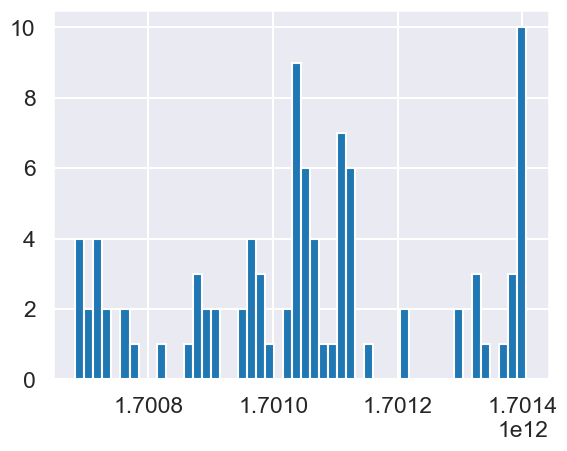

In [315]:
plt.hist(times.trial_start_time, bins=50)

#### Flag potentially weird behaviors

Flag:
- < 50% accuracy?
- button bashing on recall trials?
- fast rts on recall trials?

### Save data to csv

In [318]:
iteration_name = 'build_components_build_recall_6_towers_3_rep_color_sona_2'

In [319]:
df_learn.to_csv(experiment_results_dir + '/df_learn_{}.csv'.format(iteration_name))
# df_trial.to_csv(experiment_results_dir + '/df_trial_{}.csv'.format(iteration_name))
df_recall_trial.to_csv(experiment_results_dir + '/df_recall_trial_{}.csv'.format(iteration_name))
df_recalled_towers.to_csv(experiment_results_dir + '/df_recalled_towers_{}.csv'.format(iteration_name))
df_blocks.to_csv(experiment_results_dir + '/df_blocks_{}.csv'.format(iteration_name))

In [175]:
experiment_results_dir + '/df_blocks_{}.csv'.format(iteration_name)

'/Users/will/zipping/results/build_recall/df_blocks_build_components_build_recall_6_towers_3_rep_color_sona_pilot_0.csv'

In [53]:
# df_trial = pd.read_csv(experiment_results_dir + '/df_trial_{}.csv'.format(iteration_name))
# df_trial

,Unnamed: 0,_id,trial_start_time,trial_finish_time,condition,stimulus,response,trial_num,block_str,tower_id,...,eventType,endReason,relative_time,rep,n_resets,absolute_time,total_recall_time,submitted_towers,concatenated_towers,n_towers
0,0,64274b0ee158fd5aa12435c5,1.680297e+12,1.680297e+12,view,"{'blocks': [{'x': 0, 'y': 0, 'height': 1, 'wid...",NaN,1,0000000000000000101000001010000011110000100100...,talls_114_111,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,64274b4ee158fd5aa12435d2,1.680297e+12,NaN,build,"{'blocks': [{'x': 0, 'y': 0, 'height': 1, 'wid...",NaN,2,0000000000000000010100000101000011110000011000...,talls_097_100,...,trial_end,perfect-reconstruction-translation,59538.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
2,2,64274b5ee158fd5aa12435d3,1.680297e+12,1.680297e+12,view,"{'blocks': [{'x': 1, 'y': 0, 'height': 2, 'wid...",NaN,3,0000000000000000110100000101000001110000111100...,talls_121_101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,64274b6fe158fd5aa12435d4,1.680297e+12,1.680297e+12,view,"{'blocks': [{'x': 0, 'y': 0, 'height': 2, 'wid...",NaN,4,0000000000000000011100000110000011100000111100...,talls_102_126,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,64274b96e158fd5aa12435e8,1.680297e+12,NaN,build,"{'blocks': [{'x': 0, 'y': 0, 'height': 1, 'wid...",NaN,5,0000000000000000111000000110000001110000011000...,talls_118_114,...,trial_end,perfect-reconstruction-translation,34840.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,645,6446e103da7c3649c9c2a376,1.682366e+12,NaN,NaN,NaN,NaN,13,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,1.682367e+12,492318.0,"[{'towerDetails': {'blocks': [{'x': 4, 'y': 0,...","[{'height': 2, 'width': 1, 'x': 0, 'y': 0}, {'...",6.0
646,646,6446e20fda7c3649c9c2a419,1.682367e+12,NaN,NaN,NaN,NaN,61,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,1.682367e+12,283988.0,"[{'towerDetails': {'blocks': [{'x': 3, 'y': 0,...","[{'height': 1, 'width': 2, 'x': 0, 'y': 0}, {'...",4.0
647,647,6446e36bda7c3649c9c2a47a,1.682367e+12,NaN,NaN,NaN,NaN,13,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,1.682367e+12,733328.0,"[{'towerDetails': {'blocks': [{'x': 4, 'y': 0,...","[{'height': 2, 'width': 1, 'x': 1, 'y': 0}, {'...",6.0
648,648,6446e395da7c3649c9c2a485,1.682367e+12,NaN,NaN,NaN,NaN,13,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,1.682367e+12,135673.0,"[{'towerDetails': {'blocks': [{'x': 4, 'y': 0,...","[{'height': 2, 'width': 1, 'x': 1, 'y': 0}, {'...",4.0
